# Distance approximation (comparison with exact $\mathcal{W}_2$ computed with Python Optimal Transport library)

Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_spd_matrix
import ot

from src.optimal_transport import semi_discrete_ot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Methods to compute pairwise distances:

In [2]:
def get_embedding_distances(point_clouds, grid_size=200):
    """
    Returns the pairwise distances of 'point clouds' based on
    embedding distances.
    Args:
        point_clouds (dict): dictionary of point clouds
        grid_size (int): discretization parameter for the
                         transport plans (m in the paper)
    Returns:
        distances (array): list of pairwise embedding ditances
    """
    nb_clouds = len(point_clouds)
    # compute transport maps
    sd_ot = semi_discrete_ot(grid_size=grid_size)
    sd_ot.fit_transport_plans(point_clouds)
    # deduce transport map distances
    distances = []
    for i in range(nb_clouds-1):
        for j in range(i+1, nb_clouds):
            dist_2 = np.sum( (sd_ot.transport_plans[i]\
                            - sd_ot.transport_plans[j])**2 )
            distances.append( np.sqrt((1/(grid_size**2)*dist_2)) )
    return np.array(distances)


def get_W2_distances(point_clouds, verbose=True):
    """
    Returns the pairwise distances of 'point clouds' based on
    W2 distances (computed with the POT library).
    Args:
        point_clouds (dict): dictionary of point clouds
        verbose (boal): wether or not print computation advancment
    Returns:
        distances (array): list of pairwise Wasserstein ditances
    """
    nb_clouds = len(point_clouds)
    tot = nb_clouds * (nb_clouds-1) / 2
    count = 0
    # Define uniform weights for source and target measures
    a = np.ones(nb_points)/nb_points
    b = a.copy()
    # Wasserstein distances
    wasserstein_distances = []
    for i in range(nb_clouds-1):
        x = point_clouds[i]
        for j in range(i+1, nb_clouds):
            count += 1
            y = point_clouds[j]
            C = (x[:, 0].reshape(-1,1) - y[:, 0].reshape(1,-1))**2 \
                + (x[:, 1].reshape(-1,1) - y[:, 1].reshape(1,-1))**2
            # W2 computed with POT
            wasserstein_distances.append( np.sqrt(ot.emd2(a, b, C)) )
            if verbose:
                print("Computed {:3.1f}%".format(100*count/tot))
    return np.array(wasserstein_distances)

Method to plot distances comparison:

In [3]:
def plot_distances_comparison(wasserstein_distances, embedding_distances, title, pdf_title):
    """
    Plot distances comparison.
    Args:
        wasserstein_distances (array): list of pairwise Wasserstein distances
        embedding_distances (array): list of pairwise embedding distances
        title (str): figure title
        pdf_title (str): title for save file
    """
    f = plt.figure(figsize=(12, 7))
    plt.rcParams.update({'font.size': 25})
    # scatter distances
    plt.scatter(wasserstein_distances, embedding_distances, s=3.0)
    # add 'y=x'
    _min = min(np.min(wasserstein_distances), np.min(embedding_distances))
    _max = max(np.max(wasserstein_distances), np.max(embedding_distances))
    plt.plot([0.9*_min, 1.1*_max], [0.9*_min, 1.1*_max], '--', label='y = x', linewidth=0.8, c="r")
    # legend
    plt.xlabel(r"$W_2(\mu_M, \nu_N)$")
    plt.ylabel(r"$||T_{\mu_M} - T_{\nu_N}||_{L^2(\rho)}$") 
    plt.title(title)
    plt.legend()
    plt.show()
    # save fig
    f.savefig(pdf_title, bbox_inches='tight')

## Gaussians

Sample `nb_clouds=50` from random gaussians:

In [4]:
nb_clouds = 50 
nb_points = 300
gaussian_point_clouds = {}
sigma = 1e-2

np.random.seed(2)

for c in range(nb_clouds):
    mean = 0.25 + 0.5*np.random.rand(2) 
    cov = sigma * make_spd_matrix(2)
    gaussian_point_clouds[c] = np.random.multivariate_normal(mean, cov, nb_points)

Compute transport maps between each point cloud and the uniform measure on the unit square and deduce an estimate of $W_{2, \rho}^2(\mu_i, \mu_j) = ||T_{\mu_i} - T_{\mu_j}||_{L^2{\rho}}^2$ for all $i, j \in \{1, \dots, 50\}, i\neq j$:

In [5]:
gaussian_embedding_distances = get_embedding_distances(gaussian_point_clouds)

Compute an estimate of Wasserstein distances $W_{2}^2(\mu_i, \mu_j)$ for all $i, j \in \{1, \dots, 50\}, i \neq j$:

In [6]:
gaussian_wasserstein_distances = get_W2_distances(gaussian_point_clouds, verbose=False)

Compare the two sets of distances:

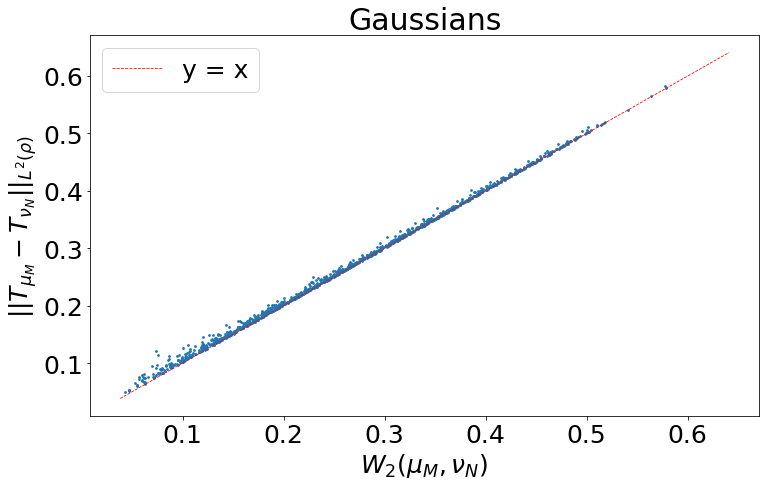

In [7]:
plot_distances_comparison(gaussian_wasserstein_distances, gaussian_embedding_distances,
                         title="Gaussians", pdf_title="W2_dT_gaussians.pdf")

## Mixture of 4 Gaussians

Sample `nb_clouds=50` from random mixtures of gaussians:

In [8]:
nb_clouds = 50
nb_points = 300
mixture_point_clouds = {}
sigma = 1e-2

np.random.seed(2)

for c in range(nb_clouds):
    cloud = np.zeros((nb_points, 2))
    for j in range(4):
        mean = 0.25 + 0.5*np.random.rand(2) 
        cov = sigma * make_spd_matrix(2)
        cloud[(j*(nb_points//4)):((j+1)*(nb_points//4))] = np.random.multivariate_normal(mean, cov, nb_points//4)
    mixture_point_clouds[c] = cloud

Compute transport maps between each point cloud and the uniform measure on the unit square and deduce an estimate of $W_{2, \rho}^2(\mu_i, \mu_j) = ||T_{\mu_i} - T_{\mu_j}||_{L^2{\rho}}^2$ for all $i, j \in \{1, \dots, 50\}, i\neq j$:

In [9]:
mixture_embedding_distances = get_embedding_distances(mixture_point_clouds)

Compute an estimate of Wasserstein distances $W_{2}^2(\mu_i, \mu_j)$ for all $i, j \in \{1, \dots, 50\}, i \neq j$:

In [10]:
mixture_wasserstein_distances = get_W2_distances(mixture_point_clouds, verbose=False)

Compare the two sets of distances:

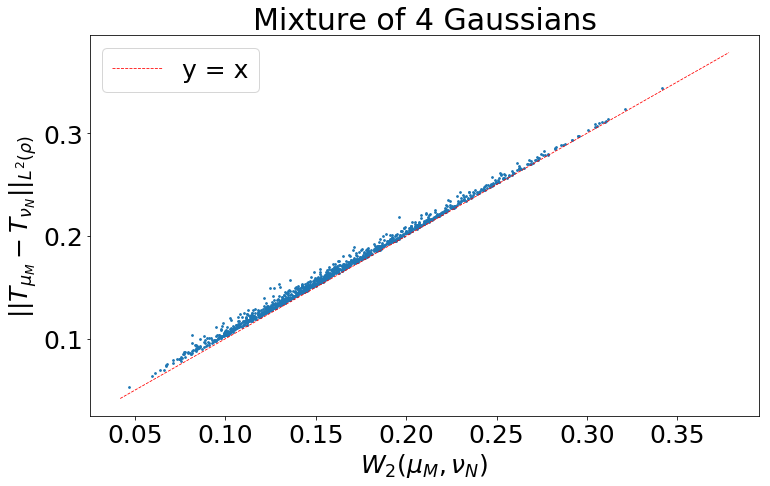

In [11]:
plot_distances_comparison(mixture_wasserstein_distances, mixture_embedding_distances,
                         title="Mixture of 4 Gaussians", pdf_title="W2_dT_mixture_4_gaussians.pdf")

## Uniform

Sample `nb_clouds=50` from the uniform distribution on $[0,1]^2$:

In [12]:
nb_clouds = 50 
nb_points = 300
uniform_point_clouds = {}

np.random.seed(2)

for c in range(nb_clouds):
    uniform_point_clouds[c] = 0.02 + 0.96 * np.random.rand(nb_points, 2)

Compute transport maps between each point cloud and the uniform measure on the unit square and deduce an estimate of $W_{2, \rho}^2(\mu_i, \mu_j) = ||T_{\mu_i} - T_{\mu_j}||_{L^2{\rho}}^2$ for all $i, j \in \{1, \dots, 50\}, i\neq j$:

In [13]:
uniform_embedding_distances = get_embedding_distances(uniform_point_clouds)

Compute an estimate of Wasserstein distances $W_{2}^2(\mu_i, \mu_j)$ for all $i, j \in \{1, \dots, 50\}, i \neq j$:

In [14]:
uniform_wasserstein_distances = get_W2_distances(uniform_point_clouds, verbose=False)

Compare the two sets of distances:

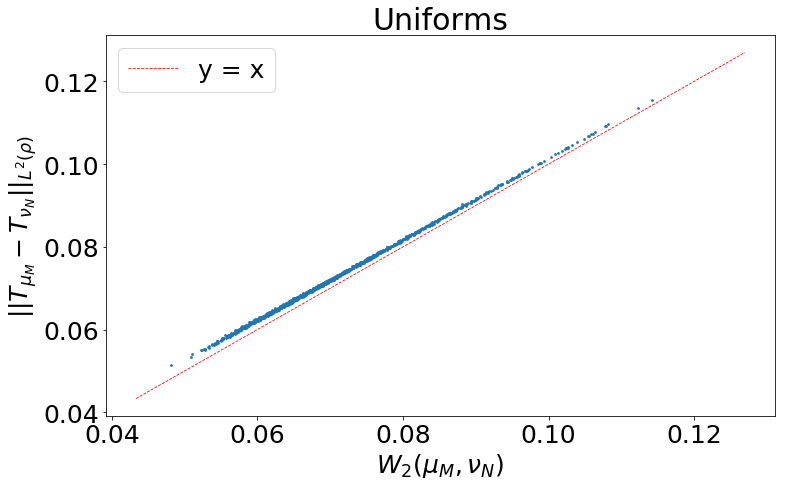

In [15]:
plot_distances_comparison(uniform_wasserstein_distances, uniform_embedding_distances,
                         title="Uniforms", pdf_title="W2_dT_uniform.pdf")